In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy


In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
import fastai; fastai.__version__

'1.0.54'

In [5]:
np.random.seed(42)

In [6]:
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [7]:
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [8]:
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [9]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [10]:
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [11]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [12]:
# src.add_test_folder('/home/ubuntu/snakes_breed/round1')

In [13]:
class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner, weights:torch.Tensor=None):
        super().__init__(learn)
        labels = self.learn.data.train_dl.dataset.y.items.astype(int)
        _,counts = np.unique(labels, return_counts=True)
        counts = 1. / counts
        self.weights = (weights if weights is not None else torch.DoubleTensor(counts[labels]))

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(
            WeightedRandomSampler(self.weights, len(self.learn.data.train_dl.dataset)),
            self.learn.data.train_dl.batch_size, False)

In [14]:
epochs = 40
lr = 1e-2
bs = 96
mixup = 0
image_size = 256

In [15]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[crop_pad()])

In [16]:
# tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [17]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize())

In [18]:
data

ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None

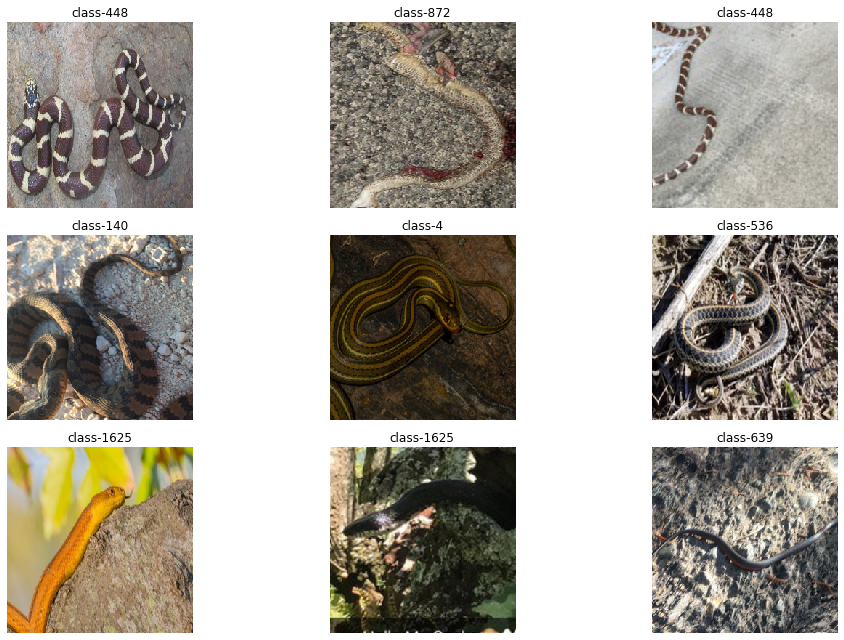

In [19]:
data.show_batch(3,figsize=(15,9))

In [20]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)


In [21]:
m = xresnet152(c_out=45)


In [22]:
loss_func = LabelSmoothingCrossEntropy()

In [23]:
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner, weights:torch.Tensor=None):
        super().__init__(learn)
        labels = self.learn.data.train_dl.dataset.y.items.astype(int)
        _,counts = np.unique(labels, return_counts=True)
        counts = 1. / counts
        self.weights = (weights if weights is not None else torch.DoubleTensor(counts[labels]))

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(
            WeightedRandomSampler(self.weights, len(self.learn.data.train_dl.dataset)),
            self.learn.data.train_dl.batch_size, False)

In [24]:
learn = (Learner(data, m, opt_func=opt_func,
             metrics=[accuracy,FBeta(beta=1,average='macro')],
             bn_wd=False, true_wd=True,callback_fns=[partial(OverSamplingCallback)],
             loss_func = loss_func)
            )

In [25]:
if mixup: learn = learn.mixup(alpha=mixup)


In [26]:
from fastai.metrics import accuracy, top_k_accuracy

top_2_accuracy = partial(top_k_accuracy, k=2)

In [27]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

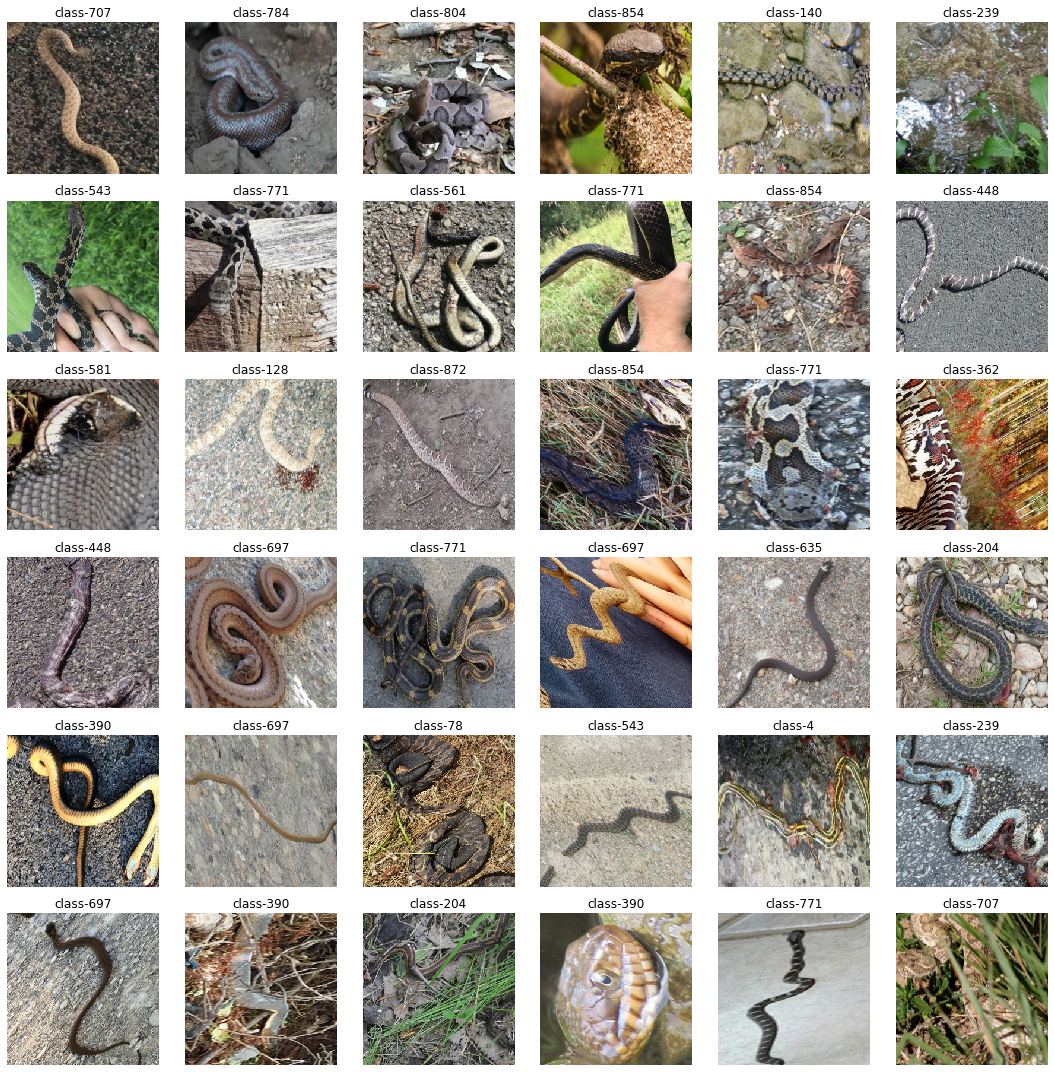

In [28]:
data.show_batch(6,figsize=(15,15))

In [29]:
learn = learn.to_fp16(dynamic=True)


In [30]:
learn.lr_find()

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


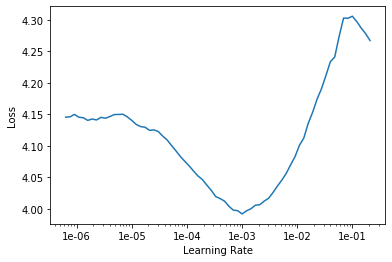

In [31]:
learn.recorder.plot()

In [32]:
lr=1e-3

In [33]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

In [34]:
learn.fit_one_cycle(epochs, lr, div_factor=10, pct_start=0.3)

In [37]:
interp = ClassificationInterpretation.from_learner(learn)


In [36]:
learn.save('c_xresnet-384-round-4-os')

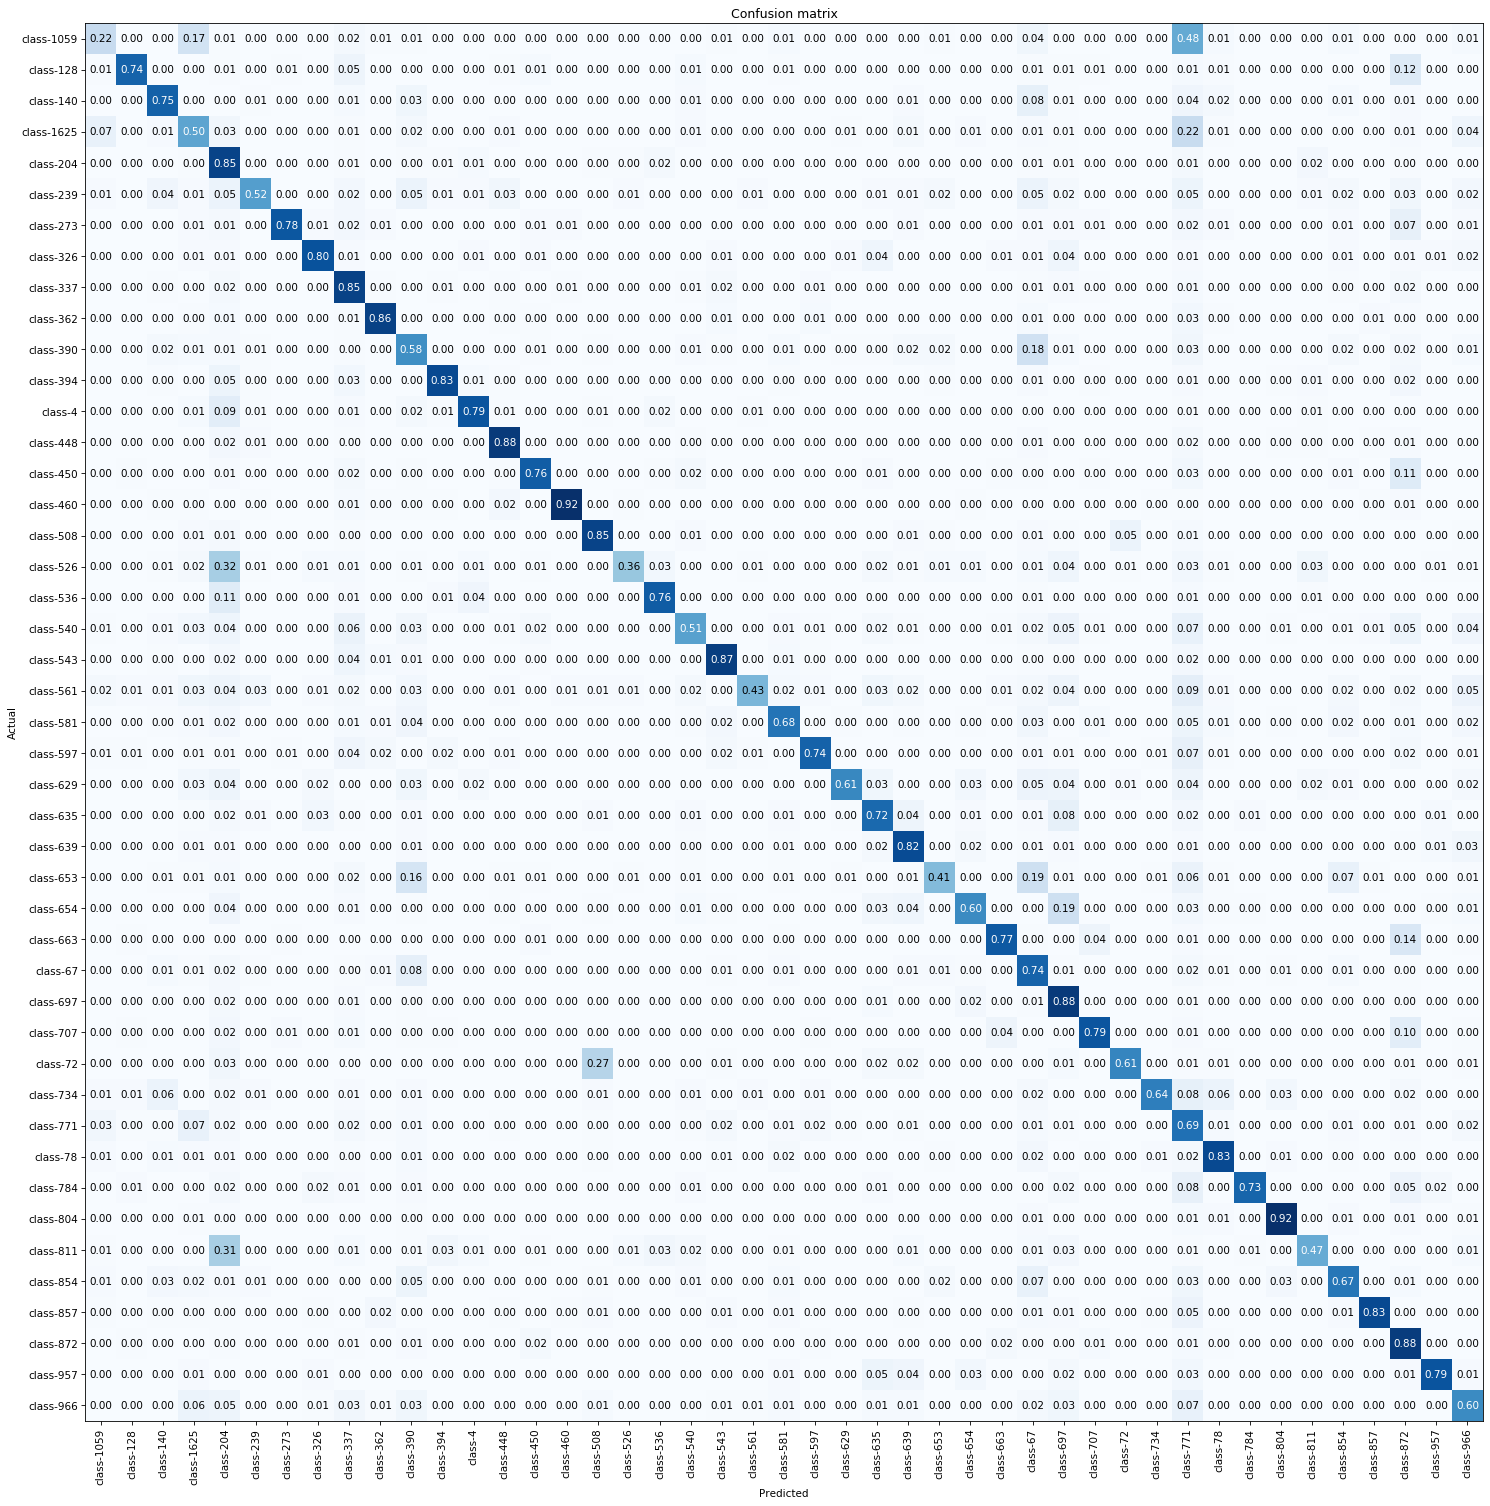

In [38]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


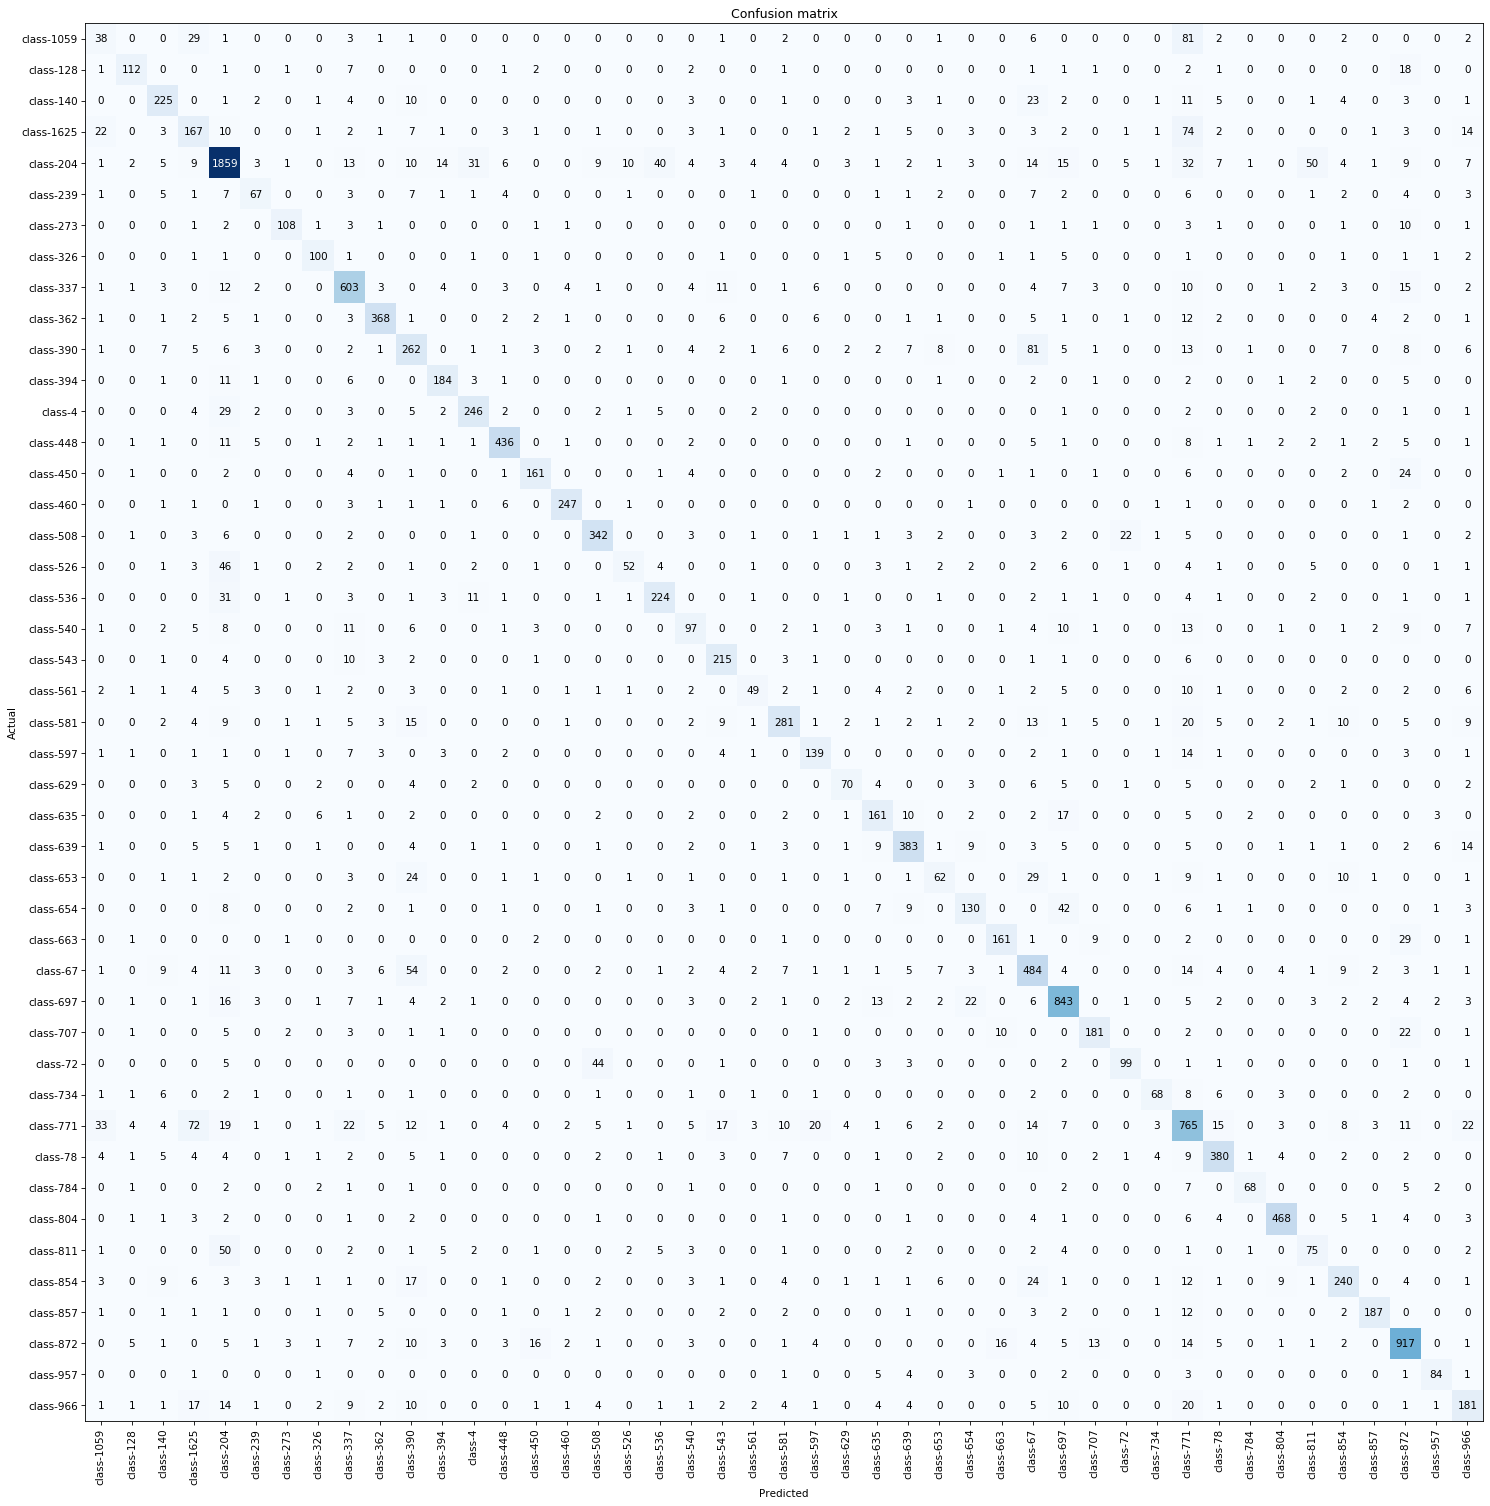

In [39]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=False)

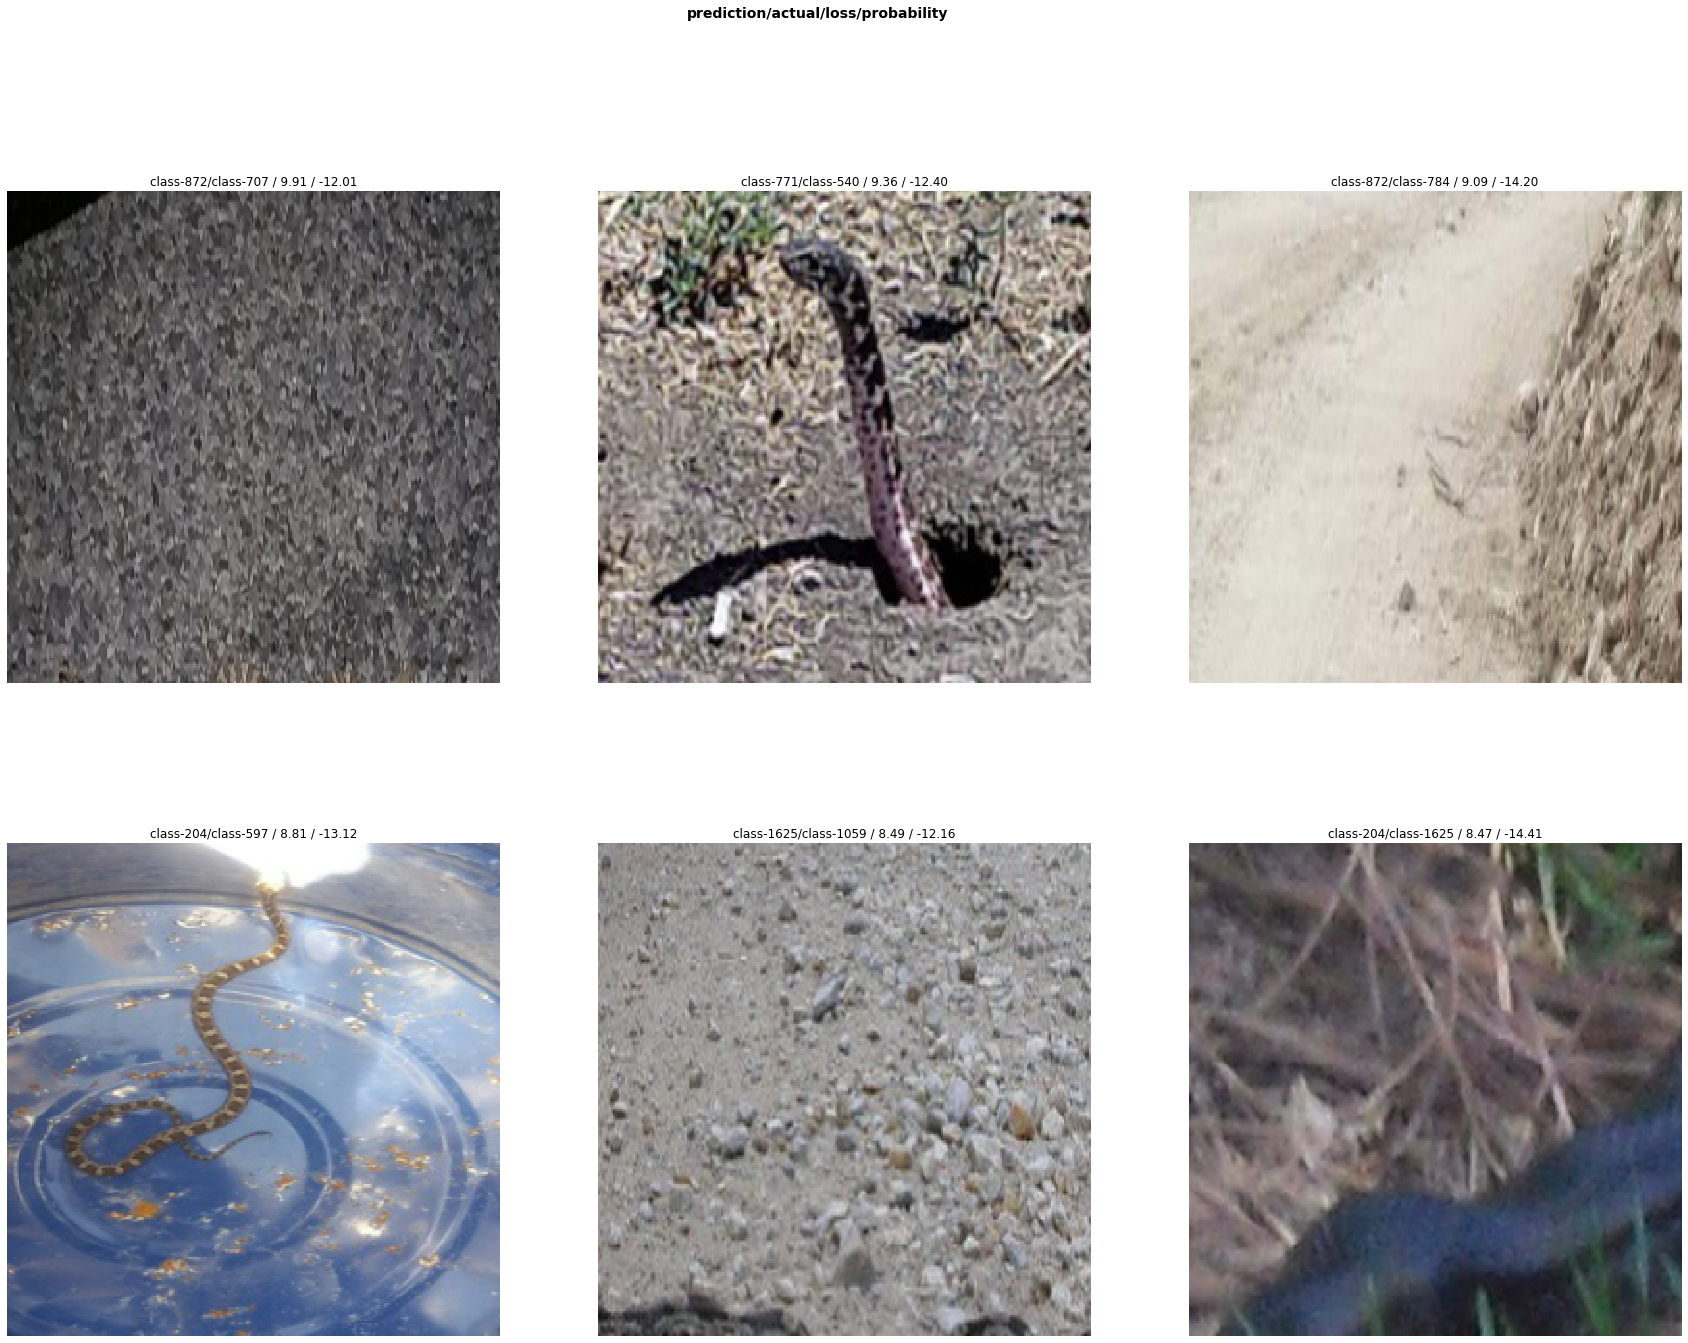

In [40]:
interp.plot_top_losses(6, figsize=(30,22))

In [41]:
learn.validate()

[1.4742267, tensor(0.7639), tensor(0.7285), tensor(0.8530)]

In [42]:
preds,_=learn.get_preds(ds_type=DatasetType.Valid)

In [43]:
preds[0]

tensor([-10.0859,  -8.5391,  -8.7656,  -4.6094,  -7.7695,  -8.0000,  -8.6094,
         -9.1875,  -8.1172,  -9.1016,  -3.8145, -10.0391,  -9.7344,  -7.8242,
         -9.2969,  -9.0234,  -9.0156,  -8.8594,  -9.2266,  -6.2500,  -8.4453,
         -9.3125,  -9.8047,  -8.5625,  -9.1641,  -9.7422,  -7.8047, -10.1484,
         -9.6797,  -9.0625,  -9.0469,  -9.7891,  -8.2656,  -8.8125,  -8.8359,
         -5.9688,  -9.3047,  -8.9531,  -8.6484, -10.1094,  -9.1562,  -9.1328,
         -7.7305,  -8.5625,  -8.8828])

In [44]:
probs = np.exp(preds) / np.exp(preds).sum(1)[:,None]

In [46]:
probs[0].sum()

tensor(1.0000)

In [47]:
probs_np = probs.numpy()

In [48]:
import numpy
numpy.savetxt("temp.csv", probs_np, delimiter=",")

In [49]:
df=pd.read_csv('temp.csv')

In [50]:
df.head()

9.710495942272245884e-04  4.560796543955802917e-03  \
0                  0.006791                  0.007201   
1                  0.034093                  0.004136   
2                  0.001000                  0.000752   
3                  0.001125                  0.001070   
4                  0.000250                  0.000361   

   3.636183682829141617e-03  2.321038097143173218e-01  \
0                  0.006184                  0.004471   
1                  0.005501                  0.147228   
2                  0.000521                  0.000666   
3                  0.001788                  0.002591   
4                  0.001194                  0.000065   

   9.845637716352939606e-03  7.819023914635181427e-03  \
0                  0.008256                  0.004930   
1                  0.001751                  0.005609   
2                  0.008242                  0.000921   
3                  0.001593                  0.001903   
4                  0.965316                  0.000680   

   4.251129459589719772e-03  2.384667517617344856e-03  \
0                  0.006112                  0.004334   
1                  0.004705                  0.005269   
2                  0.001345                  0.000606   
3                  0.001439                  0.002392   
4                  0.001533                  0.000230   

   6.954384036362171173e-03  2.598663326352834702e-03  ...  \
0                  0.004334                  0.005289  ...   
1                  0.001835                  0.001620  ...   
2                  0.001178                  0.000886  ...   
3                  0.001673                  0.001892  ...   
4                  0.001121                  0.000547  ...   

   5.960918962955474854e-02  2.120967255905270576e-03  \
0                  0.003855                  0.005586   
1                  0.654457                  0.004267   
2                  0.001215                  0.001178   
3                  0.000761                  0.001827   
4                  0.001079                  0.000490   

   3.014502115547657013e-03  4.088271409273147583e-03  \
0                  0.006871                  0.006380   
1                  0.005458                  0.002499   
2                  0.000653                  0.001073   
3                  0.001526                  0.927955   
4                  0.000342                  0.000443   

   9.485552436672151089e-04  2.460364950820803642e-03  \
0                  0.004283                  0.005608   
1                  0.003962                  0.005787   
2                  0.006886                  0.000503   
3                  0.001750                  0.001336   
4                  0.001005                  0.000110   

   2.518710913136601448e-03  1.023784372955560684e-02  \
0                  0.006232                  0.005457   
1                  0.002799                  0.002357   
2                  0.001274                  0.000342   
3                  0.002078                  0.001423   
4                  0.000207                  0.000922   

   4.455145448446273804e-03.1  3.234088653698563576e-03  
0                    0.004949                  0.003736  
1                    0.003442                  0.001030  
2                    0.000717                  0.000165  
3                    0.001152                  0.001870  
4                    0.000275                  0.002393  

[5 rows x 45 columns]

In [53]:
data.valid_ds.y.items

array([19, 33, 35, 12, ..., 22, 11, 29, 22])

In [54]:
test_temp = data.valid_ds.y.items

In [55]:
numpy.savetxt("temp_actual.csv", test_temp, delimiter=",")

In [2]:
df=pd.read_csv('temp_actual.csv')

NameError: name 'pd' is not defined

In [3]:
df.tail()

NameError: name 'df' is not defined